# Trying out tigramite for time series causal discovery.

In [1]:
%reload_ext autoreload
%autoreload 2

In [15]:
from IPython.display import display

In [13]:
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite.lpcmci import LPCMCI
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb
from tigramite.models import LinearMediation, Prediction

In [3]:
from multiprocessing import cpu_count
import sys
import networkx as nx
import matplotlib.pyplot as plt

sys.path.append('../')
from tsdr import tsdr
from diagnoser import diag
from diagnoser.diag import prepare_init_graph, filter_by_target_metrics
from meltria import loader
import diagnoser.metric_node as mn
import eval.priorknowledge as pk

In [4]:
filepath = '/datasets/argowf-chaos-hg68n/2021-12-09-argowf-chaos-hg68n-user_pod-memory-hog_1.json'
data_df, mappings = loader.read_metrics_file(filepath, exclude_middleware_metrics=True)

In [5]:
reducer = tsdr.Tsdr(tsdr.ar_based_ad_model, **{
    'tsifter_step1_ar_regression': 'n',
    'tsifter_step1_ar_anomaly_score_threshold': 0.01,
    'tsifter_step1_cv_threshold': 0.05,
    'tsifter_step1_ar_dynamic_prediction': False,
    'tsifter_step2_clustering_threshold': 0.01,
    'tsifter_step2_clustered_series_type': 'raw',
    'tsifter_step2_clustering_dist_type': 'sbd',
    'tsifter_step2_clustering_choice_method': 'medoid',
    'tsifter_step2_clustering_linkage_method': 'single',
})
_, reduced_df_by_step, metrics_dimension, _ = reducer.run(
    series=data_df,
    max_workers=cpu_count(),
)
reduced_df = reduced_df_by_step['step2']
reduced_df

,c-carts_cpu_usage_seconds_total,c-front-end_memory_usage_bytes,c-carts_cpu_cfs_periods_total,c-carts_memory_failures_total,c-carts_network_transmit_bytes_total,c-front-end_memory_failures_total,c-front-end_network_receive_bytes_total,c-front-end_cpu_usage_seconds_total,c-carts_cpu_system_seconds_total,c-carts_cpu_cfs_throttled_seconds_total,...,s-carts_latency,s-front-end_throughput,s-front-end_latency,s-payment_throughput,s-orders_latency,s-catalogue_throughput,s-shipping_throughput,s-shipping_latency,s-user_throughput,s-user_latency
0,0.353195,-1.248251,0.551464,2.011993,0.298482,1.226061,0.537089,0.627272,0.306653,-0.250494,...,-1.128338,0.003860,-0.339930,0.247081,-0.158262,0.044533,0.273250,-0.033729,0.128309,-0.267261
1,0.783190,-1.324493,0.557429,1.685917,0.858457,1.068802,0.770930,0.738189,0.906626,-0.250494,...,-0.720505,0.800029,-0.321776,0.747936,0.331712,0.744647,0.709876,-0.033729,0.705528,0.053452
2,0.430209,-1.298895,0.461927,-0.595413,0.352733,0.004894,0.473449,0.536320,0.546642,-0.250494,...,-0.312672,0.341965,-0.329203,0.290927,0.302314,0.572743,0.428443,-0.033729,0.259459,0.053452
3,0.577819,-1.326144,0.396053,-0.595413,0.650036,-0.478373,0.668354,0.611744,0.706635,-0.250494,...,0.910827,0.601269,-0.320951,0.585135,0.664895,0.399420,0.777154,-0.033729,0.596859,0.213809
4,0.289017,-1.630562,0.455176,-0.595413,0.226822,-0.363845,0.239210,0.261246,0.146660,-0.250494,...,0.910827,0.200566,-0.334979,0.099712,0.282715,0.402372,0.272948,-0.033729,0.233704,-0.106904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,-2.586174,-1.320364,-2.742400,-0.595413,-2.426939,1.505573,-2.528533,-2.462873,-2.533221,-0.250494,...,-1.128338,-2.627144,1.903668,-2.696919,-1.824174,-2.614689,-2.616221,-1.382896,-2.689142,1.496663
116,-1.976480,-1.320364,-1.878032,-0.595413,-2.363598,1.985562,-2.051533,-2.394105,-1.893249,-0.250494,...,0.910827,-2.056942,1.154427,-1.975441,-0.971619,-2.247917,-1.961206,-0.033729,-2.122151,-0.267261
117,-1.488724,-0.247745,-1.341269,-0.595413,-1.558763,2.326295,-1.485598,-1.415817,-1.493267,-0.250494,...,1.318660,-1.586886,0.390333,-1.432395,-0.628637,-1.808304,-1.424798,-0.033729,-1.654063,-0.427618
118,-0.885447,-0.247745,-0.619794,-0.595413,-0.440463,2.523599,-0.872475,-0.850141,-0.813297,-0.250494,...,0.910827,-0.875319,0.022314,-0.476716,-0.001470,-1.234051,-0.633943,-0.033729,-0.861873,-0.106904


In [6]:
dataset = filter_by_target_metrics(reduced_df)
nodes: mn.MetricNodes = mn.MetricNodes.from_dataframe(dataset)
init_g: nx.Graph = prepare_init_graph(nodes, mappings)
init_g = nx.relabel_nodes(init_g, mapping=nodes.node_to_num)

In [8]:
tau_max, tau_min = 5, 0
selected_links = {node: [ (nbr, -lag) for nbr in nbrs for lag in range(tau_min, tau_max) ]  for node, nbrs in nx.to_dict_of_lists(init_g).items()}
selected_links

{0: [(1, 0),
  (1, -1),
  (1, -2),
  (1, -3),
  (1, -4),
  (2, 0),
  (2, -1),
  (2, -2),
  (2, -3),
  (2, -4),
  (3, 0),
  (3, -1),
  (3, -2),
  (3, -3),
  (3, -4),
  (4, 0),
  (4, -1),
  (4, -2),
  (4, -3),
  (4, -4),
  (5, 0),
  (5, -1),
  (5, -2),
  (5, -3),
  (5, -4),
  (6, 0),
  (6, -1),
  (6, -2),
  (6, -3),
  (6, -4),
  (7, 0),
  (7, -1),
  (7, -2),
  (7, -3),
  (7, -4),
  (8, 0),
  (8, -1),
  (8, -2),
  (8, -3),
  (8, -4),
  (9, 0),
  (9, -1),
  (9, -2),
  (9, -3),
  (9, -4),
  (10, 0),
  (10, -1),
  (10, -2),
  (10, -3),
  (10, -4),
  (11, 0),
  (11, -1),
  (11, -2),
  (11, -3),
  (11, -4),
  (12, 0),
  (12, -1),
  (12, -2),
  (12, -3),
  (12, -4),
  (13, 0),
  (13, -1),
  (13, -2),
  (13, -3),
  (13, -4),
  (43, 0),
  (43, -1),
  (43, -2),
  (43, -3),
  (43, -4),
  (44, 0),
  (44, -1),
  (44, -2),
  (44, -3),
  (44, -4),
  (45, 0),
  (45, -1),
  (45, -2),
  (45, -3),
  (45, -4),
  (46, 0),
  (46, -1),
  (46, -2),
  (46, -3),
  (46, -4),
  (47, 0),
  (47, -1),
  (47, -2),
  (4

In [9]:
pp_frame = pp.DataFrame(
    data=dataset.values,
    var_names=dataset.columns)
parcorr = ParCorr()
pcmci_parcorr = PCMCI(dataframe=pp_frame, cond_ind_test=parcorr, verbosity=0)
# all_parents = pcmci_parcorr.run_pc_stable(tau_max=2, pc_alpha=0.2)

In [9]:
# correlations = pcmci_parcorr.get_lagged_dependencies(tau_max=tau_max, tau_min=tau_min, val_only=True, selected_links=selected_links)['val_matrix']
# lag_func_matrix = tp.plot_lagfuncs(
#     val_matrix=correlations,
#     setup_args={
#         'var_names': dataset.columns, 
#         'x_base':5, 'y_base':.5
#     }
# )
# plt.show()

In [ ]:
def filter_graph(graph):

In [20]:
results = pcmci_parcorr.run_pcmci(selected_links=selected_links, tau_max=tau_max, tau_min=tau_min)
pcmci_parcorr.print_significant_links(
    p_matrix=results['p_matrix'], 
    val_matrix=results['val_matrix'],
    alpha_level=0.01)


## Significant links at alpha = 0.01:

    Variable c-carts_memory_failures_total has 0 link(s):

    Variable c-carts_network_transmit_bytes_total has 14 link(s):
        (s-front-end_throughput  0): pval = 0.00000 | val =  0.652
        (c-front-end_cpu_usage_seconds_total  0): pval = 0.00000 | val =  0.586
        (c-front-end_network_receive_bytes_total  0): pval = 0.00000 | val =  0.565
        (s-front-end_throughput -1): pval = 0.00000 | val =  0.562
        (c-carts_cpu_system_seconds_total  0): pval = 0.00000 | val =  0.517
        (c-carts_cpu_user_seconds_total  0): pval = 0.00000 | val =  0.489
        (c-carts-db_network_transmit_bytes_total  0): pval = 0.00000 | val =  0.473
        (c-front-end_cpu_cfs_throttled_seconds_total  0): pval = 0.00000 | val =  0.456
        (c-front-end_cpu_cfs_periods_total  0): pval = 0.00004 | val =  0.378
        (c-carts_cpu_cfs_periods_total  0): pval = 0.00016 | val =  0.348
        (c-carts-db_fs_writes_total  0): pval = 0.00094 | val

In [10]:
results = pcmci_parcorr.run_pcmciplus(selected_links=selected_links, tau_max=tau_max, tau_min=tau_min)
pcmci_parcorr.print_significant_links(
    p_matrix=results['p_matrix'], 
    val_matrix=results['val_matrix'],
    alpha_level=0.01)


## Significant links at alpha = 0.01:

    Variable c-carts_cpu_usage_seconds_total has 2 link(s):
        (c-carts_cpu_system_seconds_total  0): pval = 0.00000 | val =  0.620
        (c-carts_cpu_cfs_periods_total  0): pval = 0.00000 | val =  0.547

    Variable c-front-end_memory_usage_bytes has 3 link(s):
        (c-user_fs_inodes_total -2): pval = 0.00000 | val = -0.519
        (c-orders_fs_usage_bytes  0): pval = 0.00046 | val =  0.336
        (c-user_last_seen -1): pval = 0.00812 | val =  0.257

    Variable c-carts_cpu_cfs_periods_total has 1 link(s):
        (c-carts_cpu_usage_seconds_total  0): pval = 0.00000 | val =  0.547

    Variable c-carts_memory_failures_total has 0 link(s):

    Variable c-carts_network_transmit_bytes_total has 0 link(s):

    Variable c-front-end_memory_failures_total has 0 link(s):

    Variable c-front-end_network_receive_bytes_total has 1 link(s):
        (c-carts_cpu_system_seconds_total  0): pval = 0.00982 | val =  0.250

    Variable c-front-en

In [16]:
results = pcmci_parcorr.run_pcalg(selected_links=selected_links, tau_max=tau_max, tau_min=tau_min, mode='contemp_conds')
pcmci_parcorr.print_significant_links(
    p_matrix=results['p_matrix'], 
    val_matrix=results['val_matrix'],
    alpha_level=0.01)

array([[['', '', '', '', '', ''],
        ['', '', '', '', '', ''],
        ['o-o', '', '', '', '', ''],
        ...,
        ['', '', '', '', '', ''],
        ['', '', '', '', '', ''],
        ['', '', '', '', '', '']],

       [['', '', '', '', '', ''],
        ['', '', '', '', '', ''],
        ['', '', '', '', '', ''],
        ...,
        ['', '', '', '', '', ''],
        ['', '', '', '', '', ''],
        ['', '', '', '', '', '']],

       [['o-o', '', '', '', '', ''],
        ['', '', '', '', '', ''],
        ['', '', '', '', '', ''],
        ...,
        ['', '', '', '', '', ''],
        ['', '', '', '', '', ''],
        ['', '', '', '', '', '']],

       ...,

       [['', '', '', '', '', ''],
        ['', '', '', '', '', ''],
        ['', '', '', '', '', ''],
        ...,
        ['', '', '', '', '', ''],
        ['', '', '', '', '', ''],
        ['', '', '', '', '', '']],

       [['', '', '', '', '', ''],
        ['', '', '', '', '', ''],
        ['', '', '', '', '', ''],
   


## Significant links at alpha = 0.01:

    Variable c-carts_cpu_usage_seconds_total has 2 link(s):
        (c-carts_cpu_system_seconds_total  0): pval = 0.00000 | val =  0.613
        (c-carts_cpu_cfs_periods_total  0): pval = 0.00000 | val =  0.442

    Variable c-front-end_memory_usage_bytes has 0 link(s):

    Variable c-carts_cpu_cfs_periods_total has 1 link(s):
        (c-carts_cpu_usage_seconds_total  0): pval = 0.00000 | val =  0.442

    Variable c-carts_memory_failures_total has 0 link(s):

    Variable c-carts_network_transmit_bytes_total has 1 link(s):
        (c-front-end_network_receive_bytes_total  0): pval = 0.00789 | val =  0.253

    Variable c-front-end_memory_failures_total has 17 link(s):
        (c-front-end_memory_usage_bytes -4): pval = 0.00000 | val = -0.544
        (c-front-end_memory_usage_bytes -3): pval = 0.00000 | val = -0.519
        (c-front-end_memory_usage_bytes -2): pval = 0.00000 | val = -0.441
        (c-front-end_file_descriptors -4): pval = 0.0002

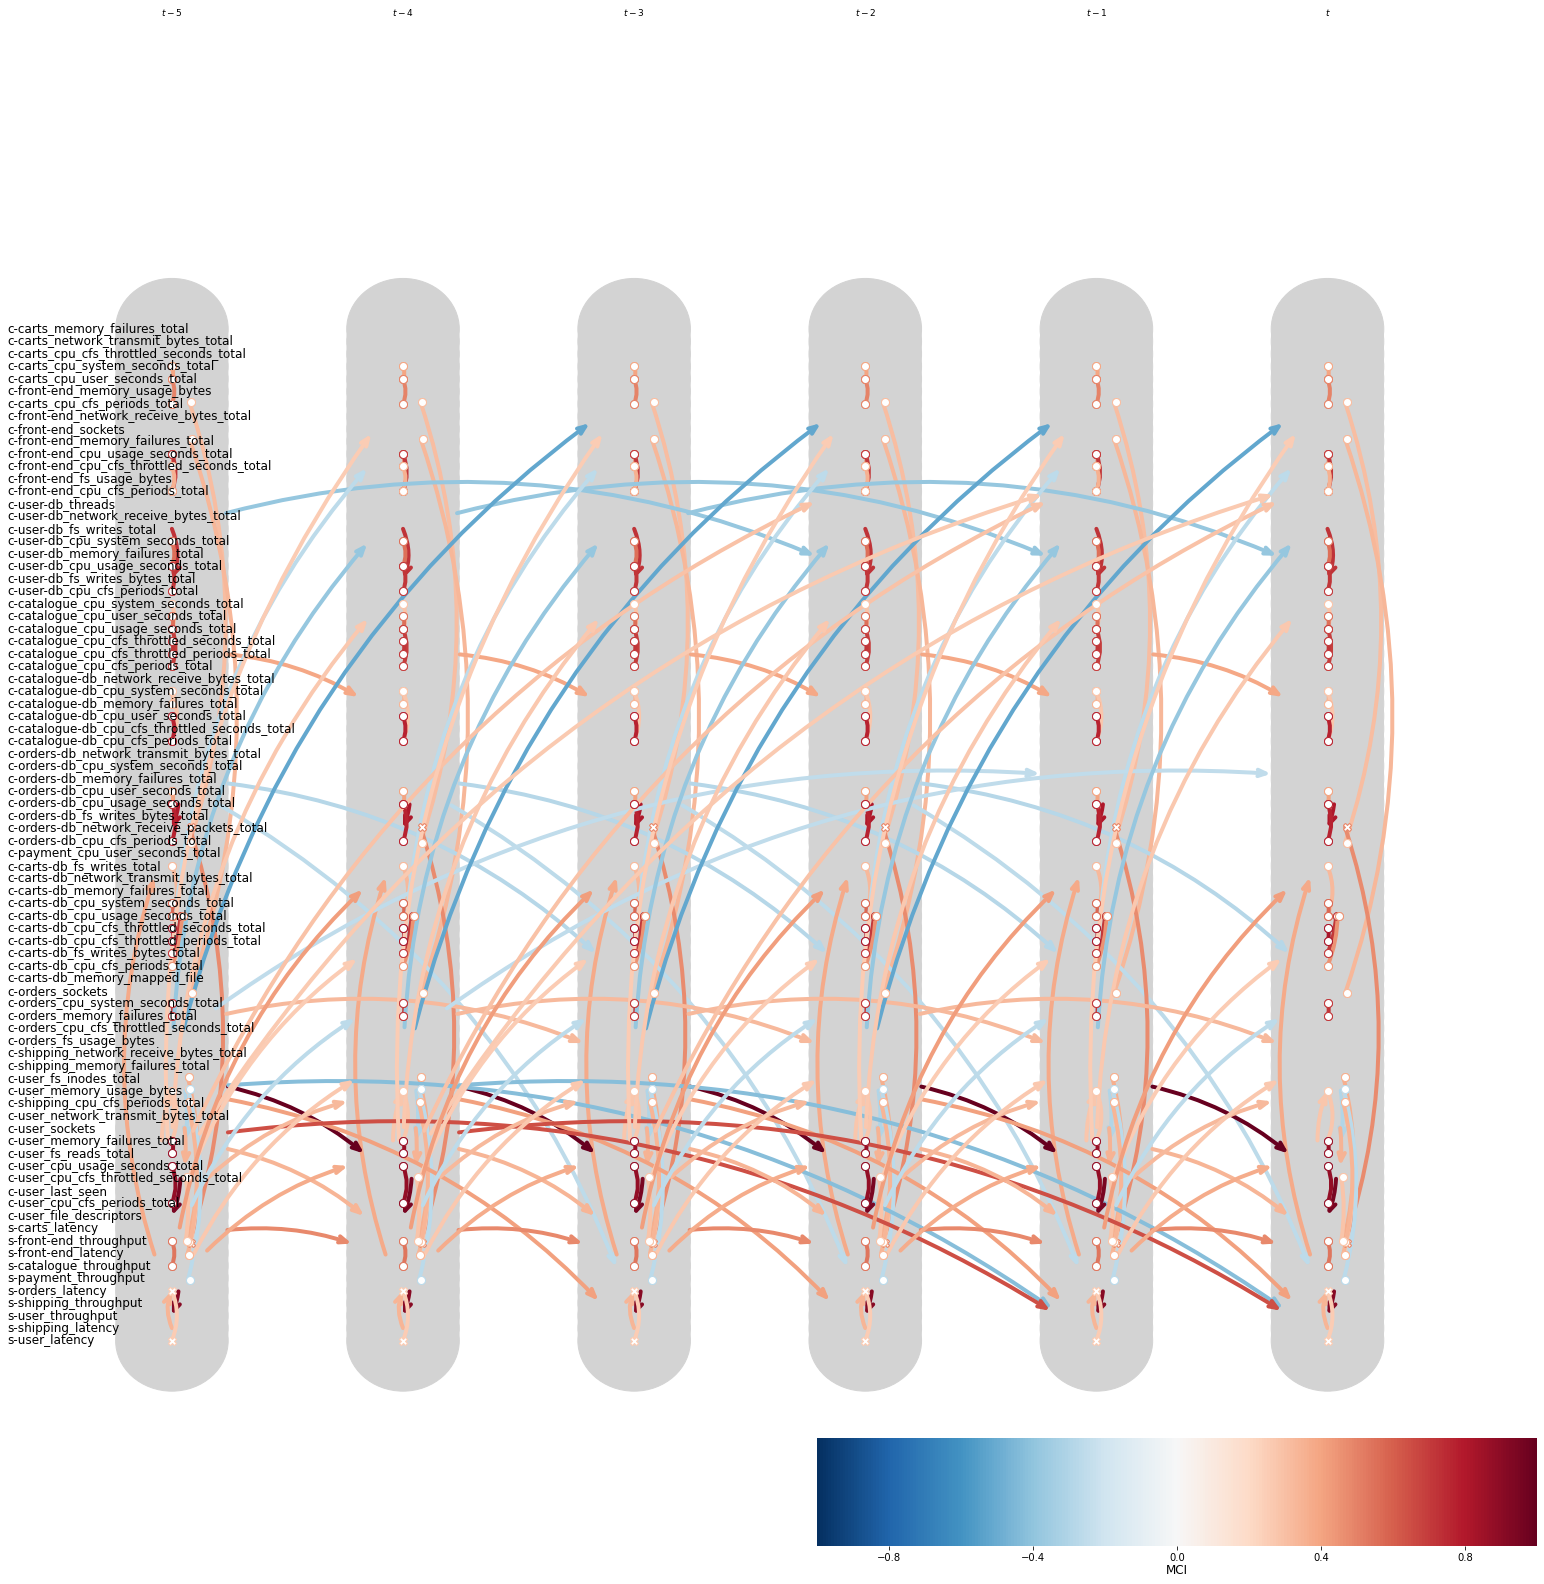

In [28]:
tp.plot_time_series_graph(
    graph=results['graph'],
    val_matrix=results['val_matrix'],
    var_names=dataset.columns,
    figsize=(25, 25),
)
plt.show()

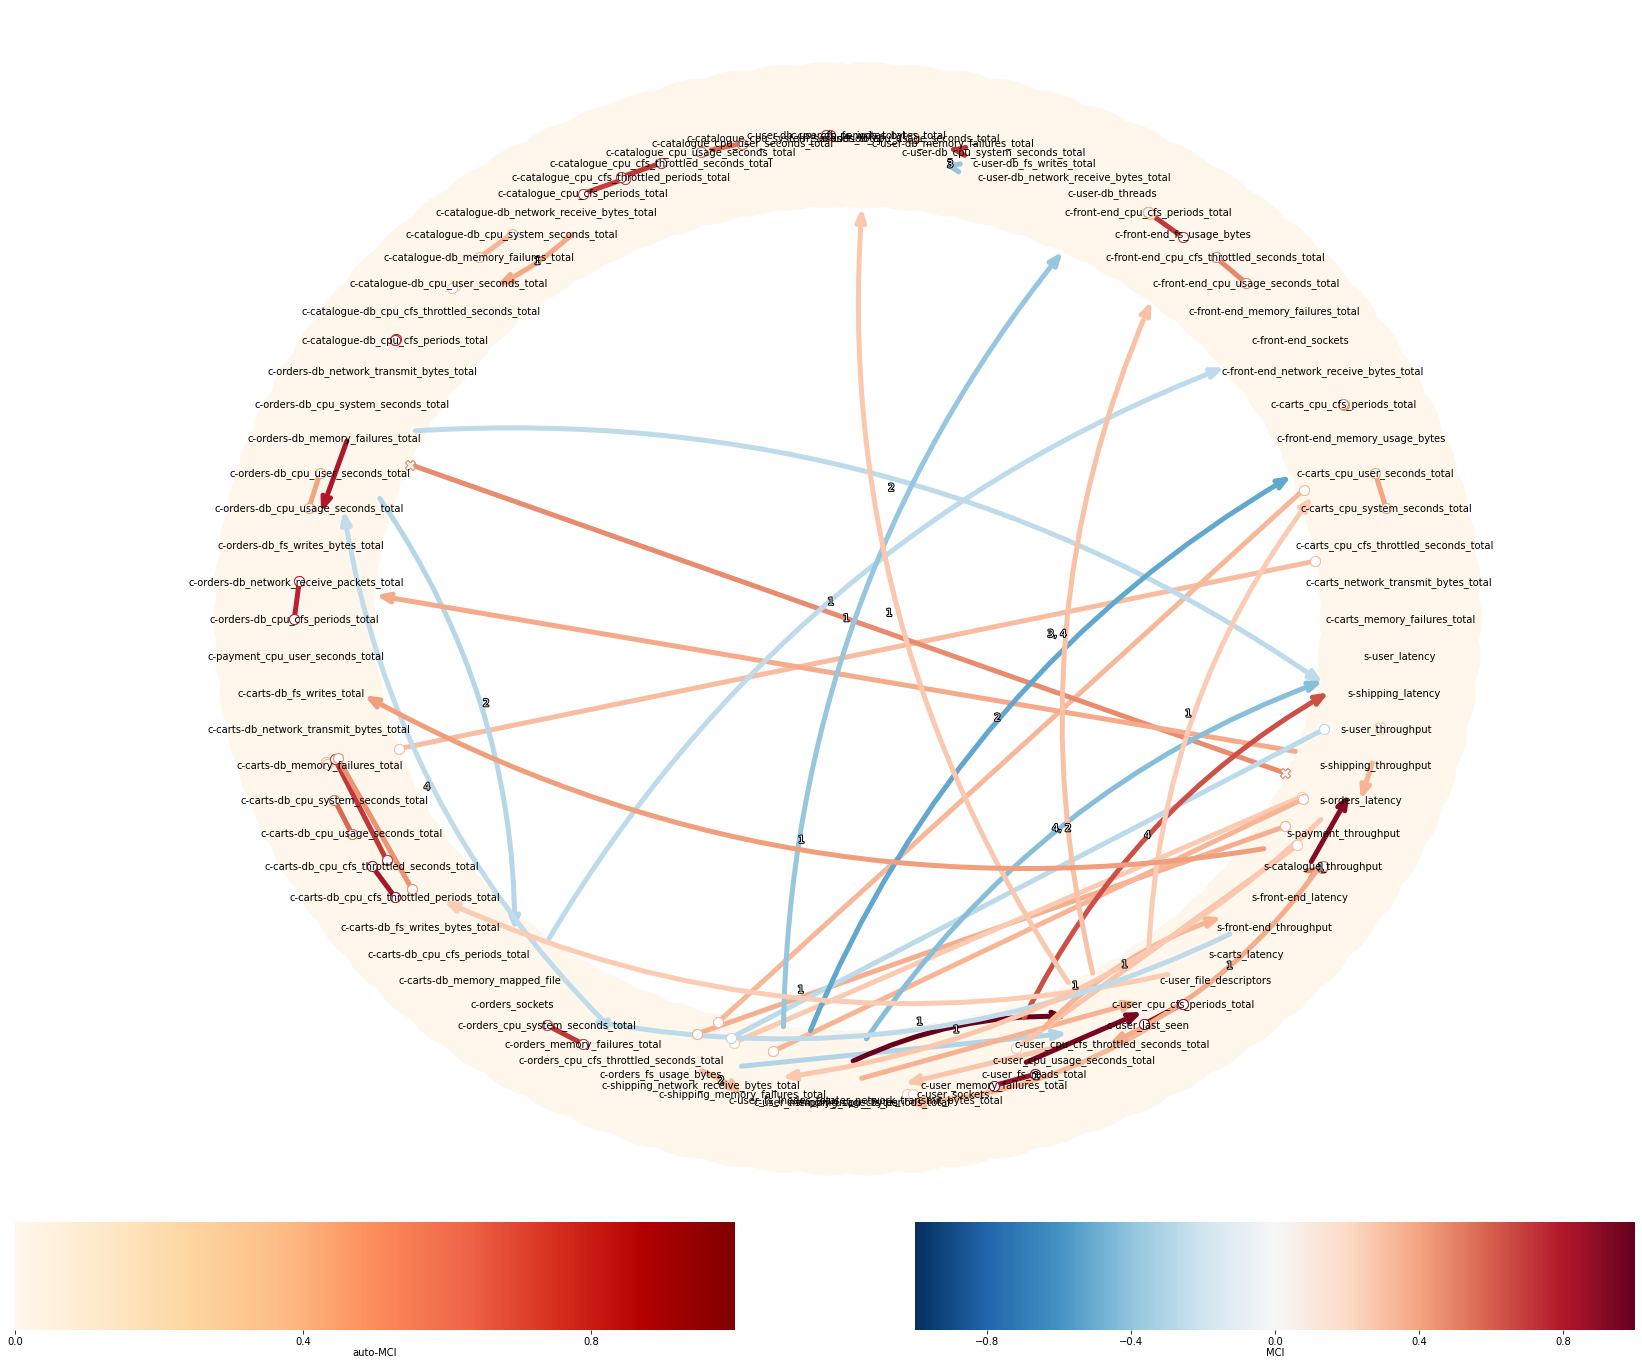

In [29]:
tp.plot_graph(
    graph=results['graph'],
    val_matrix=results['val_matrix'],
    var_names=dataset.columns,
    figsize=(25, 25),
)
plt.show()

In [14]:
lpmci = LPCMCI(dataframe=pp_frame, cond_ind_test=ParCorr())
results = lpmci.run_lpcmci(selected_links=selected_links, tau_min=tau_min, tau_max=tau_max)
results['graph']

KeyboardInterrupt: 